## Gerardo Durán Martín
### MTH739P: Topics in Scientific Computing | Coursework 2
### Queen Mary University of London | School of Mathematical Sciences

In [1]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [2]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Einsum
using TensorOperations
using StatsPlots
using Statistics
using PrettyTables

In [3]:
default(size=(600, 300))
new = [CartesianIndex()];

## Question 1: pseudospectral methods

### a) Derivative evaluation

Write a program that numerically evaluates the first derivative using pseudo-spectral methods of a function $f(x)$ evaluated a set of grid of points  $\left\{x_n = \frac{a + b}{2} + \frac{a - b}{2}\cos\theta_n\right\}_{n=0}^N$; where $a, b$ are the limits of the evaluation interval, $\theta_n = n\pi / N$. Evaluate the derivatives using the approximation

$$
    f'(x_n) = \sum_{m=0}^N D_{nm}f(x_m)
$$

Where $D_{nm}$ are the elements of the $(N+1)\times(N+1)$ Chebyshev derivative matrix given by

$$
    {\bf D}_{00} = -\frac{2N^2 + 1}{3(b-a)}
$$


$$
    {\bf D}_{nn} = \frac{\cos\theta_n}{(b-a) \sin^2\theta_n}
$$

$$
    {\bf D}_{NN} = \frac{2N^2+1}{3(b-a)}
$$


$$
    {\bf D}_{nm} = \frac{2 c_n (-1)^{n + m}}{(b-a) c_m (\cos \theta_m - \cos\theta_n)}
$$

With $c_n = 1 + \mathbb{1}(n=0) + \mathbb{1}(n=N)$

In [4]:
c(n, N) = 1 + (n == 0) + (n == N)


"""
Evaluate an entry of the chebyshev derivative matrix of a
function f:R->R evaluated from a to b in (N + 1) steps

# Arguments
- `a::Integer`: Initial value
- `b::Integer`: Final value
- `n::Integer`: row of the matrix
- `m::Integer`: column of the matrix
- `N::Integer`: Lenght of the matrix - 1


# Returns
- `::Array`: (N+1) × (N+1) chebyshev matrix
"""
function D_entry_chebyshev(a, b, n, m, N)
    n, m = n - 1, m - 1
    θn = n * pi / N
    θm = m * pi / N
    
    if n == 0 && m == 0
        D = -(2N ^ 2 + 1) / 3(b - a)
    elseif n == N && m == N
        D = (2N ^ 2 + 1) / 3(b - a)
    elseif n == m
        D = cos(θn) / ((b - a) * sin(θn) ^ 2)
    else
        D = 2c(n, N) * (-1) ^ (n + m) / ((b - a) * c(m, N) * (cos(θm) - cos(θn)))
    end
    
    return D
end


"""
Create a Chebyshev derivative matrix of a
function f:R->R evaluated from a to b in (N + 1) steps

# Arguments
- `a::Integer`: Lower bound of evaluation
- `b::Integer`: Upper bound of evaluation
- `N::Integer`: Number of gridpoints to evaluate (+1)

# Returns
- `::Array`: (N+1, N+1) matrix with Chebyshev colocation points
"""
function D_chebyshev(a, b, N)
    D = zeros(N + 1, N + 1)
    for n=1:N+1
        for m=1:N+1
            D[n, m] = D_entry_chebyshev(a, b, n, m, N)
        end
    end
    
    return D
end


"""
Create a grid point of N+1 values from
a to b to be used in the Chebyshev pseudospectral method

# Arguments
- `a::Integer`: Lower evaluation bound
- `b::Integer`: Upper evaluation bound
- `N::Integer`: Total number of evaluation points (+1)

# Returns
- `::Array{Float64,1}`: Evaluation points
"""
function range_chebyshev(a, b; length)
    θvals = (0:length) .* pi / length
    xvals = (a + b) / 2. .+ (a - b) / 2. .* cos.(θvals)
    
    return xvals
end


"""
Evaluate the derivative of a function f:R->R using a
pseudo-spectral method using a Chebyshev

# 
"""
function DChebyshev(f, a, b, N)
    xrange = range_chebyshev(a, b, length=N)
    D = D_chebyshev(a, b, N)
    # For stability and accuracy purposes, we replace each element
    # of the main diagonal with the negative sum of all matrix elements
    # in the same row
    D[diagind(D)] = -sum(D .* (ones(N+1, N+1) - I), dims=2)
    df_values = D * f.(xrange)
    
    return xrange, df_values
end


"""
# Build a differentiation matrix

This function builds a differentiation matrix required to compute
a second-order finite-differences method assuming equidistant points

# Arguments
- `x_grid::StepRangeLen`: Points at which to evaluate the derivative
- `Δx::Float`: Step size
"""
function build_diff_matrix(x_grid, Δx)
    n_grid = length(x_grid)
    D = zeros(n_grid, n_grid)
    
    for row in 1:n_grid
        if row == 1
            # Left-difference formula
            D[row, row] = -3
            D[row, row + 1] = 4
            D[row, row + 2] = -1
        elseif row == n_grid
            # Right-difference formula
            D[row, row - 2] = 1
            D[row, row - 1] = -4
            D[row, row] = 3
        else
            # Central-difference formula
            D[row, row - 1] = -1
            D[row, row] = 0
            D[row, row + 1] = 1
        end
    end
    
    D = D ./ 2Δx
    return D
end

build_diff_matrix

To demostrate how the evaluation of a derivative using pseudospectral method works, we consider the function

$$
    f(x) = \exp(-x^2)
$$

With known derivative $f'(x) = -2x\exp(-x^2)$

In [5]:
f(x) = exp(-x^2)
df(x) = -2x * exp(-x^2)

df (generic function with 1 method)

### b) Numerical error

In this section we approximate the derivative of a function $f$ and compare it against its analytical solution by plotting the difference
    
$$
    \frac{d}{dx}f_\texttt{numerical}(x) - \frac{d}{dx}f_\texttt{analytical}(x)
$$

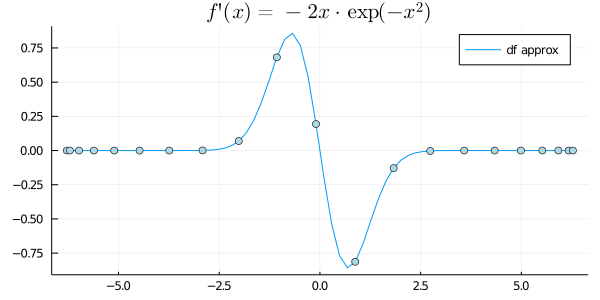

In [6]:
a, b = -2pi, 2pi
N = 101
xrange, df_approx = DChebyshev(f, a, b, N)
plot(xrange, df_approx, label="df approx", title=L"f'(x) = -2x \cdot \exp(-x^2)")
plot!(xrange[begin:5:end], df_approx[begin:5:end], marker=true, linewidth=0, label=nothing, color="lightBlue")

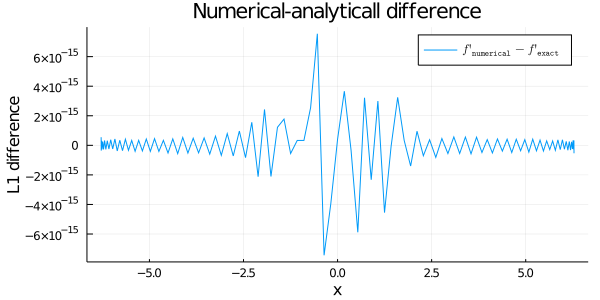

In [10]:
plot(xrange, df.(xrange) - df_approx, ylabel="L1 difference", xlabel="x",
     title="Numerical-analyticall difference", label=L"f'_\texttt{numerical} - f'_\texttt{exact}")

### c) L1 error norm

In this section we show that the difference between our numerical derivatives and the known analytical ones approaches zero.  We show this by graphing $\log\ell_1 \sim C - N$ for several values of $N$, where $\ell_1 = \sum_{n=0}^N |f'_\texttt{numerical}(x_n) - f'_\texttt{analytical}(x_n)|$

In [11]:
Nmax = 110

Nrange = 1:1:Nmax
l1_values = zeros(length(Nrange))
for (i, N) in enumerate(Nrange)
    xrange, df_approx = DChebyshev(f, a, b, N)
    l1 = sum(abs.(df.(xrange) - df_approx))
    l1_values[i] = l1
end

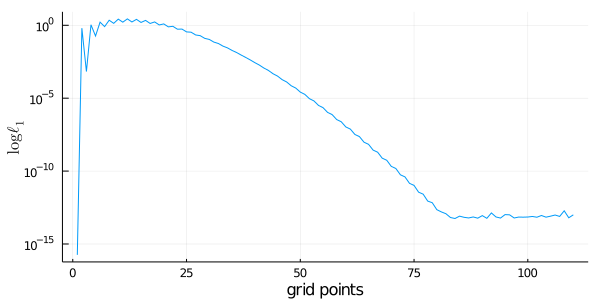

In [12]:
plot(Nrange, l1_values, label=nothing, xlabel="grid points", ylabel=L"\log\ell_1", yaxis=:log)

## Question 2: ODE Integration

Consider the pendulum described by the first-order system

$$
\begin{align*}
\frac{dq}{dt} &= p\\
\frac{dp}{dt} &= f(q)\\
\end{align*}
$$

Where $f(q) = -V'(q) = -\sin(q)$; $V(q) = 1 - \cos(q)$

In [13]:
f(q) = -sin(q)
V(q) = 1 - cos(q)

V (generic function with 1 method)

### Using Runge-Kutta 2

In this subsection, we will be using a 2nd order Runge-Kutta method to evolve the system with initial conditions.

In [14]:
"""
Implementation of a second-order Runge-Kutta ODE
solver.

# Arguments
fs: Tuple
    Collection of m functions for the ode
    ẋ = f(x)
initial_conditions: Array
    Collection of m initial conditions
Δt: float
    Timestep size
T: float / int
    Time of integration

Returns
-------
Array of size (T / Δt + 1, m) of the integration
the system from 0 to T
"""
function rk2(fs, initial_conditions, Δt, T)
    yn = initial_conditions[:]
    n_steps = Int(T / Δt + 1)
    n_params = length(initial_conditions)
    
    hist = zeros(n_steps, n_params)
    hist[1, :] = yn
    
    for ti=2:n_steps
        k1 = Δt .* [f(yn...) for f in fs]
        k2 = Δt .* [f(yn + k1 / 2...) for f in fs]
        yn = yn + k2
        hist[ti, :] = yn
    end
    
    return hist
end

rk2

In [15]:
vmin, vmax = -2pi, 2pi

xs = vmin:pi/3:vmax
ys = vmin:pi/3:vmax

df(x, y) = [y, -sin(x)] ./ 3.5

xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys];

To show our system, we evolve the system from $t=0$ to $t=100$ using $\Delta t = 0.1$ and initial conditions


$$
\begin{align*}
    q(0) &= 0\\
    p(0) &= \sqrt{2}
\end{align*}
$$

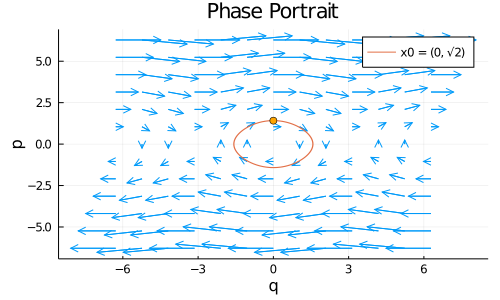

In [16]:
T = 100
dt = 0.1
system = ((q, p) -> p, (q, p) -> f(q))
cond0 = [0, sqrt(2)]
qp_hist = rk2(system, cond0, dt, T)

quiver(xxs, yys, quiver=df, size=(500, 300), xlabel="q", ylabel="p")
plot!(qp_hist[:, 1], qp_hist[:, 2], title="Phase Portrait", label="x0 = (0, √2)")
scatter!(qp_hist[1, [1]], qp_hist[1, [2]], label=nothing, color="orange")

Next, we plot the energy of the system $E$ given by

$$
    E(t) = \frac{1}{2}p^2 + V(q)
$$

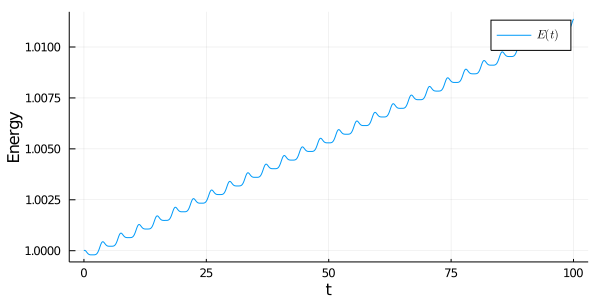

In [18]:
E = qp_hist[:, 2] .^ 2 / 2 + V.(qp_hist[:, 1])
plot(0:dt:T, E, label=L"E(t)", xlabel="t", ylabel="Energy")

As we can see, RK2 does not conserve the energy of the system. To see the effect of this change, we plot $\delta E$ defined as

$$
    \delta E(t) = E(t) - E(0)
$$

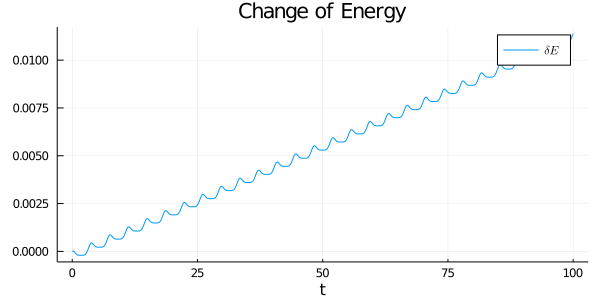

In [19]:
plot(0:dt:T, E .- E[begin], title="Change of Energy", label=L"\delta E", xlabel="t")

As we can see, in this example, the system starts to slowly gain energy.

### Using the Trapezium rule

$$
\begin{align*}
    q(t_{n+1}) - q(t_n) &\approx \frac{\Delta t}{2}[p(t_{n+1} + p_{t_n})]\\
    p(t_{n+1}) - p(t_n) &\approx \frac{\Delta t}{2}\left[f\big(q(t_{n+1})\big) + f\big(q(t_n)\big)\right]\\
\end{align*}
$$

In [20]:
"""
Implementation of a trapezoidal method to solve ODEs

# Arguments
- `fs::Tuple`: Collection of functions (f1, ..., fM) to evaluate
               ẋm = fm(x) ∀ i=1,..M
- `initial_conditions::Array{Float64, 1}`: array of initial positions
- `Δt::Float64`: timestep of integration
- `T::Float64`: Final time of integration
- `inner_it::Int64`: Number of iterations used to compute the intermediate step
"""
function trapezoidal(fs, initial_conditions, Δt, T, inner_it=10)
    yn = initial_conditions[:]
    n_steps = Int(T / Δt + 1)
    n_params = length(initial_conditions)
    
    hist = zeros(n_steps, n_params)
    hist[1, :] = yn
    
    for ti=2:n_steps
        # RK2 as initial guess
        y_old = rk2(fs, yn, dt, dt)[end, :]
        for _ in 1:inner_it
            y_new = yn + Δt / 2 .* [f(y_old...) + f(yn...) for f in fs]
            y_old = y_new
        end
        yn = y_old
        hist[ti, :] = yn
    end
    
    return hist
end

trapezoidal

To show our system, we evolve the system from $t=0$ to $t=100$ using $\Delta t = 0.1$ and initial conditions


$$
\begin{align*}
    q(0) &= 0\\
    p(0) &= \sqrt{2}
\end{align*}
$$

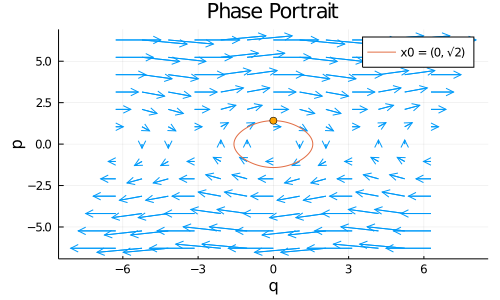

In [21]:
qp_hist = trapezoidal(system, cond0, dt, T)

quiver(xxs, yys, quiver=df, size=(500, 300), xlabel="q", ylabel="p")
plot!(qp_hist[:, 1], qp_hist[:, 2], title="Phase Portrait", label="x0 = (0, √2)")
scatter!(qp_hist[1, [1]], qp_hist[1, [2]], label=nothing, color="orange")

Next, we plot the energy of the system $E$ given by

$$
    E(t) = \frac{1}{2}p^2 + V(q)
$$

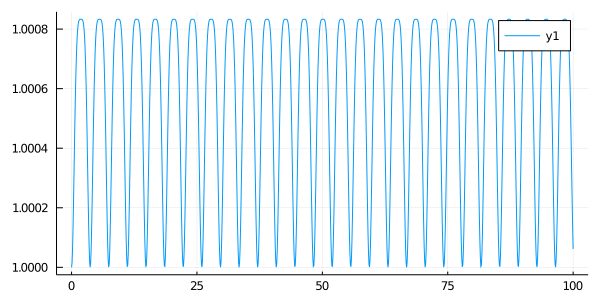

In [22]:
# Energy
E = qp_hist[:, 2] .^ 2 / 2 + V.(qp_hist[:, 1])
plot(0:dt:T, E)

The trapezium method does a decent job retaining the energy of the system (as compared to the rk2 method) since the method is time-symmetric.

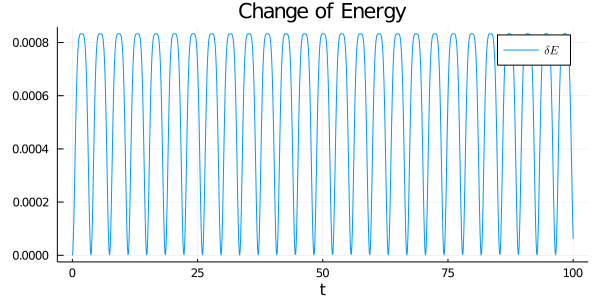

In [23]:
plot(0:dt:T, E .- E[begin], title="Change of Energy", label=L"\delta E", xlabel="t")

## Question 3: PDE Integration

$$
\partial_t^2 u - c^2 \partial_x^2 u = 0
$$

First note that if $c=1$, the solution $u_\texttt{analytical}(x) = f(t - x)$ satisfies the wave equation:

$$
\begin{align*}
    \partial_t^2 u - c^2 \partial_x^2 &= f''(t-x) - c^2 f''(t - x)\\
    &= f''(t-x) - f''(t - x)\\
    &= 0
\end{align*}
$$

Denoting $\pi = \partial_t u$, we rewrite the wave equation as follows

$$
\begin{align*}
    \dot u &= \pi\\
    \dot\pi &= c^2\partial_x^2 u
\end{align*}
$$

### b) Solving the wave equation (Runge Kutta)

In this section, we write a program that uses the method of lines to evolve the first-order reduced waved equation.

> Consider $\frac{d}{dt}{\bf u}(t) = \mathbb{L}({\bf u})$. If $\mathbb{L}$ is a linear operator, a n-th Runge-Kutta method is equivalent to an $n$th-order Taylor-series expansion.

From the previous result, we can rewrite the system as

$$
\begin{align*}
    \frac{d}{dt} u(t, x) &= \pi(t, x)\\
    \frac{d}{dt} \pi(t, x) &= c^2 \partial_x^2 u(t, x)
\end{align*}
$$

To solve this system, suppose that we've evaluated $\pi(0, x)$ and $u(0, x)$ at $N$ points each. That is, suppose we have two vectors $\boldsymbol\pi(0) = \{\pi(0, x_n)\}_{n=1}^N$ and ${\bf u} = \{u(0, x_n)\}_{n=1}^N$. If we approximate $\partial_x^2 u$ at the range of points via a differentiation matrix, we obtain

$$
\begin{align*}
    \frac{d}{dt} u(t, x)\vert_{t=0} &= \boldsymbol\pi(0)\\
    \frac{d}{dt} \boldsymbol\pi(t, x)\vert_{t=0} &= c^2 {\bf D}^2{\bf u}(0, x)
\end{align*}
$$

Since $\pi = \partial_t u = \dot u$, and $\dot u(0, x) = -c f'(x)$ we obtain our initial conditions:

$$
\begin{align*}
    \pi(0, x) &= -c f'(x)\\
    u(0, x) &= f(x)
\end{align*}
$$

For this exercise, we will be considering $f(x) = \exp(-16x^2)$ so that

$$
\begin{align*}
    \pi(0, x) &= -32x^2\exp(-16x^2)\\
    u(0, x) &= \exp(-16x^2)
\end{align*}
$$

In [24]:
f(x) = exp(-16x^2)
df(x) = -32x * exp(-16x^2)

df (generic function with 2 methods)

For the wave equation, the anallytical solution is given by

$$
    u_\texttt{analytical} = f(x - t)
$$

In [25]:
u_analytical(t, x) = f(x - t)

u_analytical (generic function with 1 method)

#### The CFL Limit

To evaluate the CFL limit using a 2nd-order Taylor expansion rule, as well as integrating one timestep ahead, we note that the system can be written as a system of ODEs of the form

$$
    \frac{d}{dt} {\bf w} = \mathbb{L}{\bf w}
$$

Where

$$
    {\bf w} =
    \begin{bmatrix}
        {\bf u} \\
        {\boldsymbol \pi} \\
    \end{bmatrix}, \quad
    \mathbb{L} = 
    \begin{bmatrix}
        {\bf 0} &  {\bf I}\\
        \mathbb{D}^2 & {\bf 0} \\
    \end{bmatrix}
$$

To approximate ${\bf w}(t)$, consider a 2nd-order taylor series approximation around $t_n$

$$
    {\bf w}(t) \approx {\bf w}(t_{n}) + \mathbb{L}({\bf w}(t) - {\bf w}(t_{n})) + \frac{1}{2}\mathbb{L}^2({\bf w}(t) - {\bf w}(t_{n}))
$$

If we integrate $\frac{d}{dt} {\bf w}(t)$ from $t_n$ to $t_{n+1}$, we see that this amounts to approximating

$$
\begin{align*}
     {\bf w}(t_{n+1}) - {\bf w}(t_{n}) &\approx \mathbb{L}\int_{t_n}^{t_{n} + \Delta t} {\bf w}(t_{n}) + \mathbb{L}({\bf w}(t) - {\bf w}(t_{n})) + \frac{1}{2}\mathbb{L}^2({\bf w}(t) - {\bf w}(t_{n})) \ dt\\
     &= \frac{\Delta t}{6}\mathbb{L}\left( 6 {\bf I} + 3\Delta t \mathbb{L} + \mathbb{L^2}(\Delta t)^2 \right) {\bf w}(t_{n})
\end{align*}
$$

Therefore, we obtain the approximation

$$
    {\bf w}(t_{n+1}) = \left( {\bf I} + \frac{\Delta t}{6}\mathbb{L}\left( 6 {\bf I} + 3\Delta t \mathbb{L} + \mathbb{L^2}(\Delta t)^2 \right) \right){\bf w}(t_{n+1})
$$


We denote ${\bf M} = \left( {\bf I} + \frac{\Delta t}{6}\mathbb{L}\left( 6 {\bf I} + 3\Delta t \mathbb{L} + \mathbb{L^2}(\Delta t)^2 \right) \right)$

If $\max\text{abs}(\text{eigvals}({\bf M})) \leq 1$, then our grid is below the courant limit

In [26]:
"""
Solve the wave equation between a and b using an
RK2 method and a chebyshev approximation to the
derivative matrix

# Arguments
- `Δt::Float64`: Time discretization
- `T::Float64`: Final time of integration
- `xmin::Float64`: left boundary
- `xmax::Float64`: right boundary
- `N::Int32`: number of steps between xmin and xmax
- `f`: function of the wave
- `df`: derivative function of the wave

# Returns
- `Array`: nits × xrange × 2
"""
function solve_wave_rk2(Δt, T, xmin, xmax, N, f, df; print_stability=false)
    D = D_chebyshev(xmin, xmax, N)
    D2 = D ^ 2
    # 'freeze' boundaries (helps us with stability)
    D2[[begin, end], :] .= 0
    xrange = range_chebyshev(xmin, xmax, length=N)
    
    # A memory-intensive way to solve it
    O = zeros(N + 1, N + 1)
    L = [O  I; 
         D2 O]
    
    M = (I + Δt / 6 * L * (6I + 3Δt * L + L ^ 2 * Δt ^ 2))

    if print_stability
        λ_max = maximum(abs.(eigvals(M)))
        println("Maximum abs-eigenvalue: $λ_max")
    end
    
    nits = Int(floor(T / Δt) + 1)
    Un = [f.(xrange); -df.(xrange)]
    U_hist = zeros(nits, 2N + 2)
    U_hist[begin, :] = Un

    for ti in 2:nits
        Un = M * Un
        U_hist[ti, :] = Un
    end

    U_hist = reshape(U_hist, (nits, N + 1, 2))
    u_numerical, pi_numerical = U_hist[:, :, 1], U_hist[:, :, 2]
end

solve_wave_rk2

In [27]:
Δt, T = 1e-4, 1
xmin, xmax, N = -3, 3, 301
nits = Int(floor(T / Δt) + 1)
xrange = range_chebyshev(xmin, xmax, length=N)
t_eval = range(0, T, length=nits)
u_numerical, pi_numerical = solve_wave_rk2(Δt, T, xmin, xmax, N, f, df, print_stability=true);

Maximum abs-eigenvalue: 1.0000000000000024


In [28]:
u_eval = u_analytical.(t_eval[:, new], xrange[new, :])
u_error = u_eval - u_numerical;
log_u_abs_error = log.(abs.(u_error));

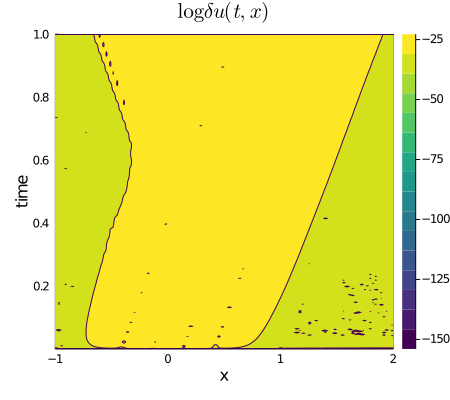

In [29]:
contourf(xrange, t_eval[2:end], log_u_abs_error[2:end, :], color=:viridis)
plot!(xlabel="x", ylabel="time", title=L"\log\delta u(t, x)", size=(450, 400), xlim=(-1, 2))

┌ Info: Saved animation to 
│   fn = /Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif
└ @ Plots /Users/gerardoduran/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif")
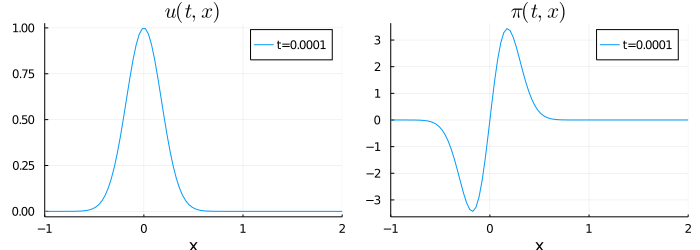

In [30]:
nframes = 20
nskip = Int(floor(nits / nframes))

@gif for i in 1:nits
    time = round(Δt * i, digits=4)
    p1 = plot(xrange, u_numerical[i, :], label="t=$time", title=L"u(t, x)", xlabel="x", xlim=(-1, 2))
    p2 = plot(xrange, pi_numerical[i, :], label="t=$time", title=L"\pi(t,x)", xlabel="x", xlim=(-1, 2))
    plot(p1, p2, layout=(1, 2), size=(700, 250), suptitle="df")
end every nskip

### c) Plotting the energy

The total energy of the system at time $t$ is given by

$$
\begin{align*}
        E(t) = \frac{1}{2}\int \big[ (\partial_t u)^2 + c^2 (\partial_x u)^2 \big] dx
\end{align*}
$$

Recalling that $c=1$, we compute the energy of the system from -1 to 1 as follows

$$
\begin{align*}
        E(t) &= \frac{1}{2}\int (\partial_t u)^2 dx + \frac{1}{2}\int (\partial_x u)^2 dx\\
        &\approx \frac{1}{2}\int \pi(t, x) ^ 2 dx + \frac{1}{2}\int \mathbb{D}{\bf u}(t, x) dx \\
        &\approx \frac{1}{2}{\bf w}^T \boldsymbol{\pi}^2(t) + \frac{1}{2}{\bf w}^T (\mathbb{D}{\bf u}(t))^2\\
        &= \frac{1}{2}{\bf w}^T\left[ \boldsymbol{\pi}^2(t) + (\mathbb{D}{\bf u}(t))^2 \right]
\end{align*}
$$

Where ${\bf w}$ is a vector of weights necessary to compute the integral from -1 to 1 using the Clenshaw-Curtis quadrature rule which is given by

$$
    w_n = \begin{cases}
    1 / N ^2 & n \in \{0, N\} \\
    \frac{2}{N}\left(1 - \sum_{k=1}^{(N-1)/2}\frac{2\cos(2k\theta_n)}{4k^2-1}\right) & n\in\{1, \ldots, N-1\}
    \end{cases}
$$

In [31]:
"""
Compute the clenshaw-curtis weights to *integrate* a
function f from a to b taking N (+1) steps

# Arguments
- `N::Integer`: Total number of (odd) steps - 1
"""
function clenshaw_curtis_weights(N, a=-1, b=1)
    weights = zeros(N + 1)
    theta_N = (0:N) .* pi / N
    for (n, theta_n) in zip(0:N, theta_N)
        if n == 0 || n == N
            w = 1 / N ^ 2
        else
            w = 2 / N * (1 - sum(2cos(2k * theta_n) / (4k^2 - 1) for k=1:((N-1)/2)))
        end
        
        weights[n+1] = w * (b - a) / 2
    end
    return weights
end

clenshaw_curtis_weights

In [32]:
xmin, xmax, N = -3, 3, 301
D = D_chebyshev(xmin, xmax, N);
w_cc = clenshaw_curtis_weights(N, xmin, xmax)

@tensor begin
    Du[t, xi] := D[xi, x] * u_numerical[t, x]
end

@einsum E[t] := w_cc[x] * (pi_numerical[t, x] ^ 2 + (Du[t, x]) ^ 2) / 2;

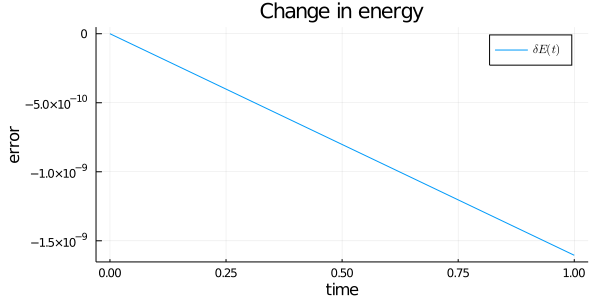

In [33]:
plot(t_eval, E .- E[begin], label=L"\delta E(t)", title="Change in energy", xlabel="time", ylabel="error")

For Runge Kutta methods, we notice a loss in energy since the procedure **is not time symmetric**.

### Going above the Courant limit

We note that sligtly going above the Courant limit impacts heavily in the error

In [34]:
Δt, T = 2.8e-4, 1
xmin, xmax, N = -3, 3, 301
u_numerical, pi_numerical = solve_wave_rk2(Δt, T, xmin, xmax, N, f, df, print_stability=true);

Maximum abs-eigenvalue: 1.0598729120509873


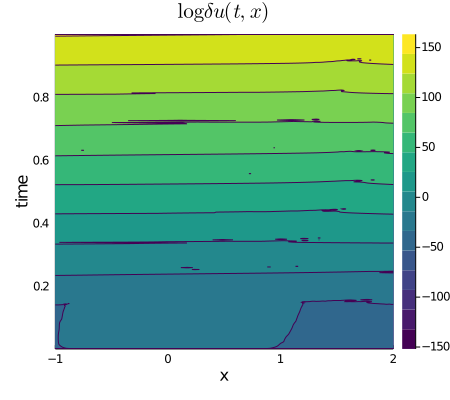

In [35]:
t_eval = 0:Δt:T
u_eval = u_analytical.(t_eval[:, new], xrange[new, :])
u_error = u_eval - u_numerical;
u_abs_error = abs.(u_error)
contourf(xrange, t_eval[2:end], log.(u_abs_error[2:end, :]), color=:viridis)
plot!(xlabel="x", ylabel="time", title=L"\log\delta u(t, x)", size=(450, 400), xlim=(-1, 2))

### d) Solving the wave equation (Trapezium)

In this section, we write a program that uses the method of lines to evolve the first-order reduced waved equation.

As before, we consider the ODE system

$$
\begin{align*}
    \dot u &= \pi\\
    \dot\pi &= c^2\partial_x^2 u
\end{align*}
$$

With $\pi = \partial_t u$

The trapezium reule fot the wave equation yields a system of the form

$$
\begin{align*}
    {\bf u}_{n+1} - {\bf u}_n &= \int_{t_n}^{t_{n+1}} {\boldsymbol\pi}(t) dt \approx \frac{\Delta t}{2}(\boldsymbol\pi_{n+1} + \boldsymbol\pi_{n})\\
    {\boldsymbol \pi}_{n+1} - {\boldsymbol \pi}_n &= \int_{t_n}^{t_{n+1}} {\bf D}^2{\bf u}(t) dt \approx \frac{\Delta t}{2}{\bf D}^2({\bf u}_{n+1} + {\bf u}_{n})\\
\end{align*}
$$

Solving the system for ${\bf u}_{n+1}$, $\boldsymbol\pi_{n+1}$ yields

$$
    \boldsymbol\pi_{n+1} \approx \left[{\bf I} - \frac{(\Delta t)^2}{4}{\bf D}^2 \right]^{-1}\left[ \left({\bf I} + \frac{(\Delta t)^2}{4}{\bf D}^2\right)\boldsymbol\pi_{n} + \Delta t {\bf D}^2 {\bf u}_n\right]
$$

$$
    {\bf u}_{n+1} \approx \frac{\Delta t}{2} (\boldsymbol\pi_{n+1} + \boldsymbol\pi_{n}) + {\bf u}_n
$$

In order to increase the accuracy of the method, we will be using compensated summations. In order to induce a compensated summation, we consider $\boldsymbol\pi_{n+1} - \boldsymbol\pi_{n}$ and rewrite it as follows:

$$
    \boldsymbol\pi_{n+1} = \boldsymbol\pi_n + \left({\bf I} - \frac{\Delta t^2}{4}{\bf D}^2\right)\left(\frac{\Delta t^2}{2}{\bf D}^2 \boldsymbol\pi_n + \Delta t {\bf D}^2 {\bf u}_n\right)
$$

#### The CFL Limit

To evaluate the CFL limit using the trapezium rule, we recall that the system can be written as a system of ODEs of the form

$$
    \frac{d}{dt} {\bf w} = \mathbb{L}{\bf w}
$$

Where

$$
    {\bf w} =
    \begin{bmatrix}
        {\bf u} \\
        {\boldsymbol \pi} \\
    \end{bmatrix}, \quad
    \mathbb{L} = 
    \begin{bmatrix}
        {\bf 0} &  {\bf I}\\
        \mathbb{D}^2 & {\bf 0} \\
    \end{bmatrix}
$$

Then, we approximate a timestep integral as

$$
    {\bf w}_{n+1} - {\bf w}_{n} \approx \mathbb{L}\frac{\Delta t}{2}[{\bf w}_{n+1} + {\bf w}_{n}]
$$

This implies

$$
    {\bf w}_{n+1} = \left({\bf I} - \frac{\Delta t}{2}\mathbb{L} \right)^{-1}\left({\bf I} + \frac{\Delta t}{2}\mathbb{L} \right) {\bf w}_n
$$

We denote ${\bf M} = \left({\bf I} - \frac{\Delta t}{2}\mathbb{L} \right)^{-1}\left({\bf I} + \frac{\Delta t}{2}\mathbb{L} \right)$

If $\max\text{abs}(\text{eigvals}({\bf M})) \leq 1$, then our grid is below the courant limit

In [36]:
"""
Solve the wave equation between a and b using the
Trapezium method and a chebyshev approximation to the
derivative matrix

# Arguments
- `Δt::Float64`: Time discretization
- `T::Float64`: Final time of integration
- `xmin::Float64`: left boundary
- `xmax::Float64`: right boundary
- `N::Int32`: number of steps between xmin and xmax
- `f`: function of the wave
- `df`: derivative function of the wave

# Returns
- `Array`: nits × xrange × 2
"""
function solve_wave_trapezium(Δt, T, xmin, xmax, N, f, df)
    D = D_chebyshev(xmin, xmax, N)
    D2 = D ^ 2
    # 'freeze' boundaries (helps us with stability)
    D2[[begin, end], :] .= 0
    xrange = range_chebyshev(xmin, xmax, length=N)
    
    u_n = f.(xrange)
    π_n = -df.(xrange);
    
    nits = Int(floor(T / Δt) + 1)
    U_hist = zeros(nits, 2, N + 1)
    U_hist[begin, 1, :] = u_n
    U_hist[begin, 2, :] = π_n

    M1 = I - Δt ^ 2 / 4 * D2
    M1_inv = inv(M1)
    
    
    for ti=2:nits
        M2 = Δt ^ 2 / 2 * D2 * π_n + Δt * D2 * u_n
        π_n1 = M1_inv * M2 + π_n
        u_n1 = Δt / 2 * (π_n + π_n1) + u_n
        U_hist[ti, 1, :] = u_n1
        U_hist[ti, 2, :] = π_n1

        u_n = u_n1
        π_n = π_n1
    end
    
    u_numerical, pi_numerical = U_hist[:, 1, :], U_hist[:, 2, :]
    
end

solve_wave_trapezium

In [37]:
Δt, T = 1e-4, 1
xmin, xmax, N = -3, 3, 301
t_eval = 0:Δt:T
u_numerical, pi_numerical = solve_wave_trapezium(Δt, T, xmin, xmax, N, f, df);

In [38]:
xrange = range_chebyshev(xmin, xmax, length=N)
u_eval = u_analytical.(t_eval[:, new], xrange[new, :])
u_error = u_eval - u_numerical
u_abs_error = abs.(u_error);

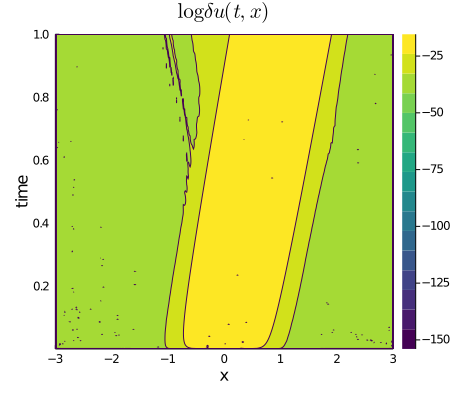

In [39]:
contourf(xrange, t_eval[2:end], log.(u_abs_error)[2:end, :], color=:viridis)
plot!(xlabel="x", ylabel="time", title=L"\log\delta u(t, x)", size=(450, 400))

┌ Info: Saved animation to 
│   fn = /Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif
└ @ Plots /Users/gerardoduran/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif")
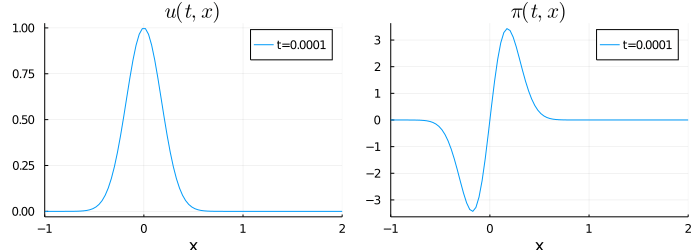

In [40]:
nframes = 20
nskip = Int(floor(nits / nframes))

@gif for i in 1:nits
    time = round(Δt * i, digits=5)
    p1 = plot(xrange, u_numerical[i, :], label="t=$time", title=L"u(t, x)", xlabel="x", xlim=(-1, 2))
    p2 = plot(xrange, pi_numerical[i, :], label="t=$time", title=L"\pi(t,x)", xlabel="x", xlim=(-1, 2))
    plot(p1, p2, layout=(1, 2), size=(700, 250), suptitle="df")
end every nskip

### d.2) Plotting the energy

The total energy of the system at time $t$ is given by

$$
\begin{align*}
        E(t) = \frac{1}{2}\int \big[ (\partial_t u)^2 + c^2 (\partial_x u)^2 \big] dx
\end{align*}
$$

As with the previous exercise, we approximate the energy as follows:

$$
\begin{align*}
        E(t) &\approx \frac{1}{2}{\bf w}^T\left[ \boldsymbol{\pi}^2(t) + (\mathbb{D}{\bf u}(t))^2 \right]
\end{align*}
$$

Where ${\bf w}$ is a vector of weights necessary to compute the integral from -1 to 1 using the Clenshaw-Curtis quadrature rule which is given by

$$
    w_n = \begin{cases}
    1 / N ^2 & n \in \{0, N\} \\
    \frac{2}{N}\left(1 - \sum_{k=1}^{(N-1)/2}\frac{2\cos(2k\theta_n)}{4k^2-1}\right) & n\in\{1, \ldots, N-1\}
    \end{cases}
$$

In [41]:
D = D_chebyshev(xmin, xmax, N);
w_cc = clenshaw_curtis_weights(N, xmin, xmax)

@tensor begin
    Du[t, xi] := D[xi, x] * u_numerical[t, x]
end

@einsum E[t] := w_cc[x] * (pi_numerical[t, x] ^ 2 + (Du[t, x]) ^ 2) / 2;

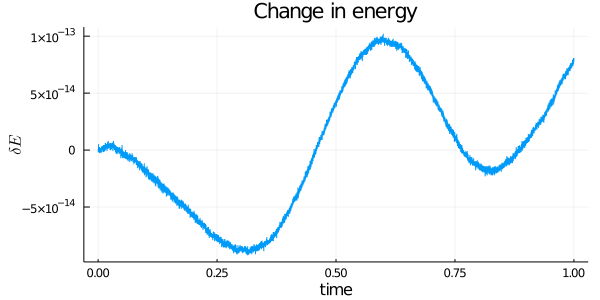

In [42]:
plot(0:Δt:T, E .- E[begin], label=nothing, title="Change in energy", xlabel="time", ylabel=L"\delta E")

For the trapezium method, we notice that the total energy is considerably well conserved since this method is time symmetric.

### Going above the Courant limit

Since the trapezium method is time symmetric, the maximum absolute eigenvalue is below or equal to 1. We show this empirically by decreasing $\Delta x$ and increasing $\Delta t$

In [43]:
Δt, T = 1e-2, 1.5
xmin, xmax, N = -3, 3, 501
t_eval = 0:Δt:T
u_numerical, pi_numerical = solve_wave_trapezium(Δt, T, xmin, xmax, N, f, df);

In [44]:
nits, _ = size(u_numerical)

(151, 502)

In [45]:
D = D_chebyshev(xmin, xmax, N)
D2 = D ^ 2
# 'freeze' boundaries (helps us with stability)
D2[[begin, end], :] .= 0

O = zeros(N + 1, N + 1)
L = [O  I; 
     D2 O]
M = inv(I - Δt / 2 * L) * (I + Δt / 2 * L)
λ_max = maximum(abs.(eigvals(M)))
println("Maximum abs-eigenvalue: $λ_max")

Maximum abs-eigenvalue: 1.000000000000037


In [46]:
xrange = range_chebyshev(xmin, xmax, length=N)
u_eval = u_analytical.(t_eval[:, new], xrange[new, :])
u_error = u_eval - u_numerical
log_u_abs_error = log.(abs.(u_error));

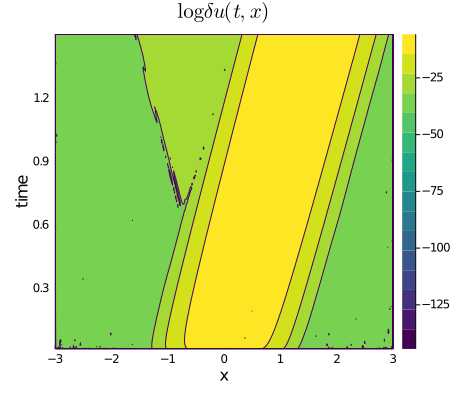

In [47]:
contourf(xrange, t_eval[2:end], log_u_abs_error[2:end, :], color=:viridis)
plot!(xlabel="x", ylabel="time", title=L"\log\delta u(t, x)", size=(450, 400))

## Question 4: Generating Random Numbers

For the probability distributions detailed below, we will construct functions to obtain random numbers sampled from these distributions.

### 4.a) Uniform distribution over the interval $[-2\pi, \pi]$

In [48]:
U = rand(Float64, 30_000);

In [49]:
f(x, a, b) = (a <= x <= b) / (b - a);

In [50]:
eps = π/10
a, b = -2π, π
X = a .+ (b - a) * U;

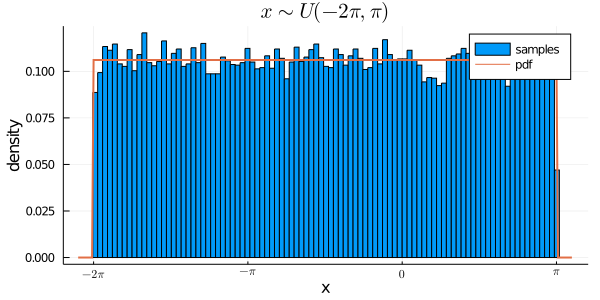

In [51]:
xrange = a-eps:π/100:b+eps
xticks = -2π:π:3π
xticks_labels = [L"-2\pi", L"-\pi", L"0", L"\pi"]
histogram(X, bins=100, norm=true, label="samples")
plot!(xrange, f.(xrange, a, b), label="pdf", linewidth=2)
plot!(xticks=(xticks, xticks_labels), xlabel="x", ylabel="density", title=L"x\sim U(-2\pi, \pi)")

### 4.b) Uniform distribution over the union of the three intervals $[1, 2] \cup [3, 4] \cup [5, 6]$

The pdf for this distribution does not have an exact solution, therefore, for each $x_i$ sampled from our U(0, 1) distribution, we perform the bisection algorithm to find the inverse value $F_Y^{-1}(x_i)$

In [52]:
"""
Implement the bisection method to find the root
of a function, i.e., find x such that f(x) = 0.
To do so, the function requires a, b in R such that
(f(a) > 0 and f(b) < 0) or ((f(a) < 0 and f(b) > 0))
"""
function bisection(f, a, b; tol=1e-10)
    c = (a + b) / 2
    err = Inf
    
    while err > tol
        c = (a + b) / 2
        fc = f(c)
        
        if sign(fc) == sign(f(a))
            a = c
        else
            b = c
        end
        
        err = abs(fc)
    end
    return c
end


"""
Compute the Cumulative Distribution Function (CDF) for
a random variable that is distributed uniformly over the
union of three intervals [a, b] ∪ [c, d] ∪ [e, f]. We assume
that
        a < b < c < d < e < f

- `y::Float64`: Evaluates p(Y <= y)
- `a::Float64`: First lower bound
- `b::Float64`: First upper bound
- `c::Float64`: Second lower bound
- `d::Float64`: Second upper bound
- `e::Float64`: Third lower bound
- `f::Float64`: Third upper bound
"""
function F(y, a=1, b=2, c=3, d=4, e=5, f=6)
    I1 = a < y < b
    I2 = c < y < d
    I3 = e < y < f

    
    if y <= a
        Fy = 0
    elseif y < b
        Fy = (y - a) / 3(b - a)
    elseif y < d
        Fy = 1 / 3 + I2 * (y - c) / 3(d - c)
    elseif y < f
        Fy = 2 / 3 + I3 * (y - e) / 3(f - e)
    else
        return 1
    end
    
    return Fy
        
    
end

f(x, a, b, c, d, e, f) = (a < x < b) / 3(b - a) + (c < x < d) / 3(d - c) + (e < x < f) / 3(f - e)

f (generic function with 3 methods)

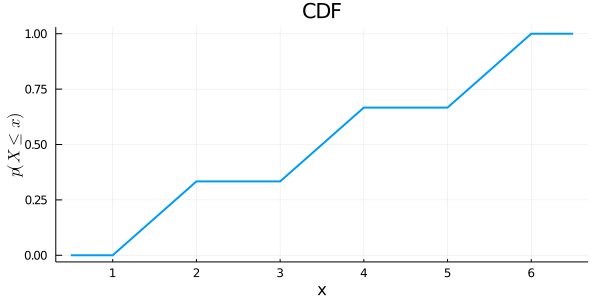

In [53]:
xrange = 0.5:0.01:6.5
plot(xrange, F.(xrange), legend=nothing, linewidth=2)
plot!(title="CDF", xlabel="x", ylabel=L"p(X \leq x)")

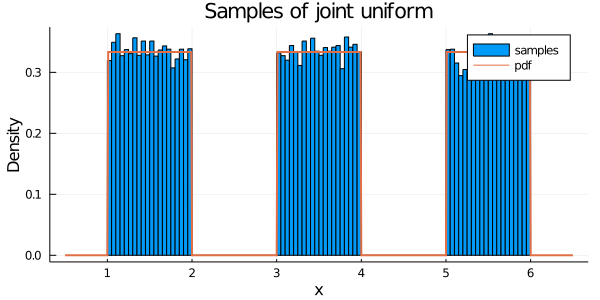

In [54]:
X = [bisection(y -> F(y) - x, 0, 7) for x in U]
histogram(X, bins=100, norm=true, label="samples")
plot!(xrange, f.(xrange, 1, 2, 3, 4, 5, 6), linewidth=2, label="pdf")
plot!(xlabel="x",ylabel="Density", title="Samples of joint uniform")

### 4.c)  Gaussian distribution with a given mean value $\mu$ and variance $\sigma^2$ using the box-muller algorithm

The Box-Muller algorithm is as follows:

1. Generate pairs $(x_1,x_2)$ of $U(-1,1)$ random variables
2. For each pair of random variables, define

$$
\begin{align*}
    y_1 &= \sqrt{-2\ln x_1}\cos(2\pi x_2)\\
    y_2 &= \sqrt{-2\ln x_1}\sin(2\pi x_2)
\end{align*}
$$

It follows that $y_1\bot y_2$ and $\forall i. y_i\sim \mathcal{N}(0,1)$

In [55]:
N = 10_000
X2 = rand(Float64, (N, 2));

In [56]:
Y2 = zeros(N, 2)

n_obs = 1
for (x1, x2) in eachrow(X2)
    y1 = sqrt(-2log(x1)) * cos(2pi * x2)
    y2 = sqrt(-2log(x1)) * sin(2pi * x2)

    Y2[n_obs, 1] = y1
    Y2[n_obs, 2] = y2

    n_obs += 1
end

σ = 3
μ = 12.5

Y2 = Y2[begin:n_obs-1, :] * σ .+ μ;

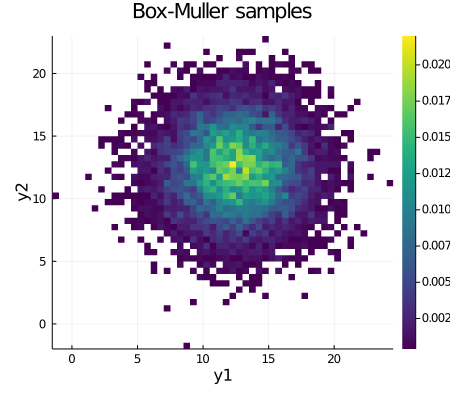

In [57]:
histogram2d(Y2[:, 1], Y2[:, 2], bins=90, color=:viridis, norm=true)
plot!(size=(450, 400), xlabel="y1", ylabel="y2", title="Box-Muller samples")

In [58]:
function N_pdf(x; μ, σ)
    pdf = exp(-1/(2σ^2) * (x - μ) ^ 2) / sqrt(2π * σ^2)
end

N_pdf (generic function with 1 method)

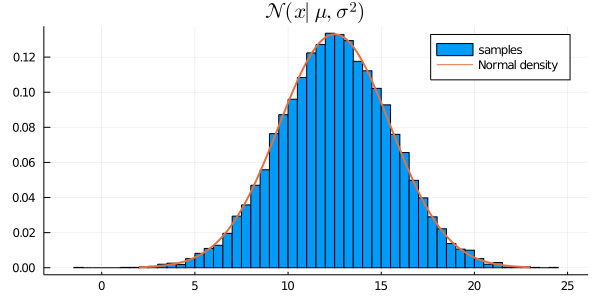

In [59]:
xrange = 2:0.1:23
yrange = N_pdf.(xrange, μ=μ, σ=σ)

histogram(Y2[:, 1], norm=true, label="samples")
plot!(xrange, yrange, linewidth=2, label="Normal density")
plot!(title=L"\mathcal{N}(x | \mu, \sigma^2)")

### 4.d) Continuous distribution with probability density function


$$
    f(x \vert \lambda) = \lambda \exp(-\lambda x)
$$

To find the CDF $F(x)$, consider

$$
\begin{align*}
F(x) &= \int_0^x f(\hat x) d\hat x\\
     &= \int_0^x \lambda \exp(-\lambda \hat x) d\hat x\\
     &=  - \exp(-\lambda \hat x) \big\vert_{\hat x=0}^x \\
     &= - (\exp(-\lambda x) -  \exp(0))\\
     &= 1 - \exp(-\lambda x) 
\end{align*}
$$

Next, to find the inverse function, consider

$$
\begin{align*}
    y &= 1 - \exp(-\lambda x) \\
    y + 1 &= \exp(-\lambda x) \\
    \log(-y + 1) &= -\lambda x\\
    \frac{-1}{\lambda} \log(-y + 1) &= x
\end{align*}
$$

In [60]:
f(x, λ) = λ * exp(-λ * x)
Finv(y, λ) = -log(-y + 1) / λ;

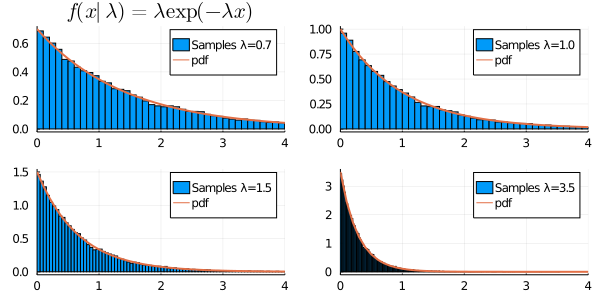

In [61]:
xrange = 0:0.1:4
lambdas = [0.7, 1, 1.5, 3.5]
labels = ["Samples λ=$λ" for λ in lambdas][new, :]
p = histogram(Finv.(U[:, new], lambdas[new, :]), layout=4, normed=true, xlim=(0, 4), labels=labels)
plot!(xrange, f.(xrange[:, new], lambdas[new, :]), linewidth=2, layout=4, label="pdf")

p.subplots[1].attr[:title] = L"f(x | \lambda) = \lambda \exp(-\lambda x)"
p

### 4.e) Continuous distribution with cumulative density function

$$
    F(x) = \frac{1}{6}(x^2 + x); x\in[0, 2]
$$

$$
    f(x) = \frac{d}{dx}F(x) = \frac{1}{6}(2x + 1)
$$

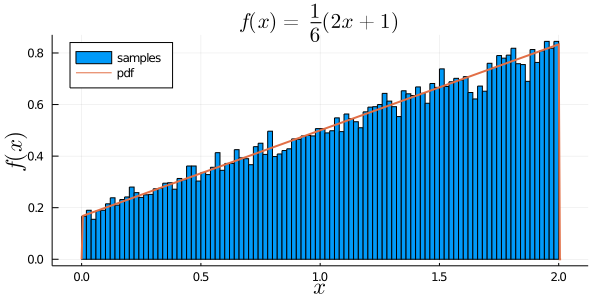

In [62]:
F(x) = (0 <= x <= 2) * (x ^ 2 + x) / 6 + (x > 2)
f(x) = (0 < x <= 2) * (2x + 1) / 6
X = [bisection(y -> F(y) - x, 0, 2) for x in U]
xrange = 0:0.005:2.01
histogram(X, bins=100, norm=true, label="samples")
plot!(xrange, f.(xrange), linewidth=2, label="pdf")
plot!(legend=:topleft, title=L"f(x) = \frac{1}{6}(2x + 1)", xlabel=L"x", ylabel=L"f(x)",
    xguidefontsize=15, yguidefontsize=15)

## Question 5: Importance sampling

Considering the integral

$$
    I = \int_0^1 x^3 (1 - x)^{1/2} dx = \frac{32}{315}
$$

which is the value of the Euler-Beta function

$$
    B(a, b) = \int_0^1 x^{a-1}(1-x)^{b-1} dx
$$

for $a=4$ and $b=3/2$

### 5.a) Montecarlo estimate

Construct a function to determine a Monte-Carlo estimate $I_U$ of $I$ using $N=1000$ uniform random variables in $[0, 1]$, and provide the absolute value of the estimate and the corresponding Mean Squared Error.

In [63]:
a, b = 4, 3 / 2
beta_kernel(x; a, b) = x ^ (a - 1) * (1 - x) ^ (b - 1)

beta_kernel (generic function with 1 method)

In [64]:
N = 1000
U = rand(Float64, N);

In [65]:
I_exact = 32 / 315

0.10158730158730159

In [66]:
g(x) = x ^ 3 * sqrt(1 - x)
I_approx = mean(g.(U))

0.10345196612326095

In [67]:
I_error = abs(I_exact - I_approx)
round(I_error, digits=5)

0.00186

In [68]:
mse = var(g.(U))

0.0074452319984376365

### 5.b) Importance sampling

Determine a Monte-Carlo estimate of I using importance sampling. Choose $N = 1000$ random variables with a probability density function $f(x) = 5x^4$, $x\in[0,1]$ as sampling points. Provide the absolute error of the estimate. How much does this estimate improves/deteriorates over the one obained in point (a) through simple sampling?

Suppose we want to sample from a distribution $p(z) = \frac{1}{Z_p}\tilde p(z)$. Suppose we do not know $Z_p$, but we can evaluate $\tilde p(z)$. Furthermore, suppose that we have $L$ i.i.d. (independent and identically distributed) samples $\{z_\ell\}_{\ell=1}^L$ such that $\forall \ell. z_\ell \sim q$, and suppose that we can evaluate $q(z)$. Then, note that

$$
\begin{align*}
    Z_p &= \int \tilde p(z) dz\\ 
        &= \int \frac{\tilde p(z)}{q(z)} q(z) dz \\
        &\approx \frac{1}{L}\sum_{\ell=1}^L \frac{\tilde p(z^{(\ell)})}{q(z^{(\ell)})}
\end{align*}
$$

This last result shows that we can evaluate $Z_p$ from $q$ and $\tilde p$, and is known as the importance sampling algorithm.

In [69]:
# First, we approximate numerically the value Zp that we are looking for
N = 20
xrange = range_chebyshev(0, 1, length=N)
weights = clenshaw_curtis_weights(N, 0, 1.1)
dot(weights, f.(xrange))

0.36638925438596504

In [70]:
n = 5
f(x, n) = (0 <= x <= 1) * n * x ^ (n - 1)
zvals = U .^ (1/n);

Next, we approximate $I_\texttt{exact}$ by the importance sampling procedure defined above.

In [71]:
importance_weights = beta_kernel.(zvals, a=a, b=b) ./ f.(zvals, n)
I_approx = mean(importance_weights)
I_error = abs(I_approx - I_exact)
round(I_error, digits=5)

0.00051

### 5.c) Importance sampling (II)

Now repeat point (b) by trying the three functions $f_1(x) = 4x^3$, $f_2(x) = 3x^2$ and
$f_3(x) = 2x$ as the sampling distributions for importance sampling, considering
$N = 1000$ samples in each case. Compare the results with those obtained in point (a)
and (b). Which of the four estimates is the most accurate? Can you provide an
explanation of the results you obtained

In [72]:
n_values = 5:-1:2

header = ["n" "I_approx" "I_error"]
data = zeros(length(n_values), 3)

for (i, n) in enumerate(n_values)
    zvals = U .^ (1 / n)
    importance_weights = beta_kernel.(zvals, a=a, b=b) ./ f.(zvals, n)
    I_approx = mean(importance_weights)
    I_error = I_approx - I_exact
    data[i, 1] = n
    data[i, 2] = round(I_approx, digits=5)
    data[i, 3] = round(abs(I_error), digits=5)
end

hmin = Highlighter((data,i,j) -> i == argmin(data[:, end]),
                    bold=true,
                    background=:red)

pretty_table(data, header, highlighters=(hmin))

┌─────┬──────────┬─────────┐
│   n │ I_approx │ I_error │
├─────┼──────────┼─────────┤
│ 5.0 │  0.10108 │ 0.00051 │
│ 4.0 │  0.10126 │ 0.00033 │
│ 3.0 │  0.10169 │  0.0001 │
│ 2.0 │  0.10264 │ 0.00105 │
└─────┴──────────┴─────────┘


Out of the 5 methods, the importance sampling estimate with $n=3$ was the most accurate. This is due the *most* proportion of mass assigned by the function $f_2(x)$ relative to the Beta-kernel function.